In [1]:
import numpy as np
import pandas as pd
import scipy.ndimage

## Generate datas

First we need to generate the data corresponding to these keys: 'geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'sim_time'.

These keys have dimensions (37, 256, 128). 37 corresponds to the pressure level in the atmosphere and (256, 128) corresponds to the coordinates on the earth. 256 is a simplified dimension for longitude and 128 is a simplified dimension for latitude.

We're going to generate data on a simplified model by reducing the dimension by around 8. We therefore have this dimension for our simplified model: (5, 32, 16)

For example, for the ‘geopotential’ key, we will generate data based on the density of these 5 pressure levels:

Level :  0
- Mean : 465315
- Standard deviation : 14729
- Min Value : 427966
- Max Value : 482014


Level :  8
- Mean : 199837
- Standard deviation : 5439
- Min Value : 183852
- Max Value : 204361


Level :  16
- Mean : 101209
- Standard deviation : 5618
- Min Value : 90911
- Max Value : 108308


Level :  24
- Mean : 34489
- Standard deviation : 2438
- Min Value : 28310
- Max Value : 37926


Level :  32
- Mean : 9146
- Standard deviation : 1322
- Min Value : 3201
- Max Value : 11682

In [2]:
levels = [
    {"mean": 465315, "std": 14729, "min": 427966, "max": 482014},
    {"mean": 199837, "std": 5439, "min": 183852, "max": 204361},
    {"mean": 101209, "std": 5618, "min": 90911, "max": 108308},
    {"mean": 34489,  "std": 2438, "min": 28310, "max": 37926},
    {"mean": 9146,   "std": 1322, "min": 3201, "max": 11682}
]

generated_geopotential = np.empty((5, 32, 16))

for i, level in enumerate(levels):
    data = np.random.normal(loc=level["mean"], scale=level["std"], size=(32, 16))
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    data = np.clip(data, level["min"], level["max"])
    generated_geopotential[i] = data

generated_geopotential.shape


(5, 32, 16)

In [4]:
levels = [
    {'mean': 3.8344e-06, 'std': 1.564e-07, 'min': 3.0758e-06, 'max': 4.0835e-06},
    {'mean': 2.818e-06, 'std': 8.4e-08, 'min': 2.5599e-06, 'max': 3.2926e-06},
    {'mean': 6.09523e-05,'std': 8.11908e-05,'min': 3.2823e-06,'max': 0.0004949116},
    {'mean': 0.0018833724,'std': 0.0021755043,'min': 1.4893e-05,'max': 0.010320779},
    {'mean': 0.005408603,'std': 0.0049265353,'min': 6.23738e-05,'max': 0.017578755}
    ]

generated_specific_humidity = np.empty((5, 32, 16))

for i, level in enumerate(levels):
    data = np.random.normal(loc=level["mean"], scale=level["std"], size=(32, 16))
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    data = np.clip(data, level["min"], level["max"])
    generated_specific_humidity[i] = data

generated_specific_humidity.shape

(5, 32, 16)

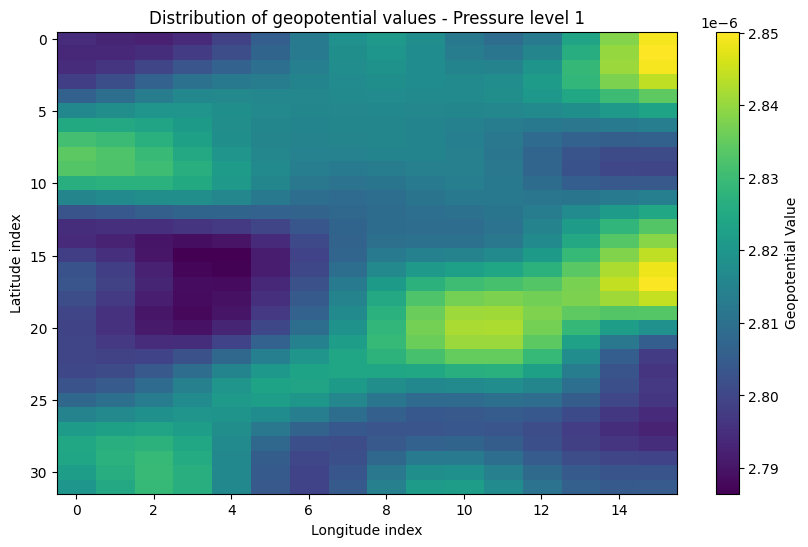

In [5]:
import matplotlib.pyplot as plt

level_1_data = generated_specific_humidity[1]

plt.figure(figsize=(10, 6))
plt.imshow(level_1_data, cmap='viridis', aspect='auto')
plt.colorbar(label="Geopotential Value")
plt.title("Distribution of geopotential values - Pressure level 1")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()